In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import seaborn as sns

In [4]:
sns.set_context('paper', font_scale=2.2)
sns.set_style('ticks')

In [5]:
import LB_colony_growth.LB_colony_growth as lb
from LB_colony_growth.node_types import node_types

# Setting up the domain

Look at the 2-d ipython notebook for better documentation. It is a relatively straightforwards to move from 2d to 3d. This example simulates a spherical tumor that grows and forms rough domains. 

In [8]:
dimension = 3

workgroup_x = 32
workgroup_y = 4
workgroup_z = 4
print 'num in workgroup:', workgroup_x*workgroup_y*workgroup_z

halo = 1 #ALWAYS 1 for this system.

nx = 150
ny = 150
nz = 150

print 'num in domain:', nx*ny*nz/1.e6 , 'million'

num in workgroup: 512
num in domain: 3.375 million


In [9]:
ctx_info = {}
ctx_info['num_type'] = 'double'

ctx_info['nx'] = nx
ctx_info['ny'] = ny
ctx_info['nz'] = nz

ctx_info['local_size'] = (workgroup_x, workgroup_y, workgroup_z)
ctx_info['domain_size'] = (nx, ny, nz)

ctx_info['dimension'] = dimension

ctx_info['kernel_arguments'] = {}

In [10]:
bc_map = np.zeros((nx + 2*halo, ny + 2*halo, nz + 2*halo), dtype=lb.int_type)

bc_map[...] = node_types['FLUID_NODE']

# Assign walls on all edges
bc_map[0, :, :] = node_types['WALL_NODE']
bc_map[:, 0, :] = node_types['WALL_NODE']
bc_map[:, :, 0] = node_types['WALL_NODE']
bc_map[-1, :, :] = node_types['WALL_NODE']
bc_map[:, -1, :] = node_types['WALL_NODE']
bc_map[:, :, -1] = node_types['WALL_NODE']

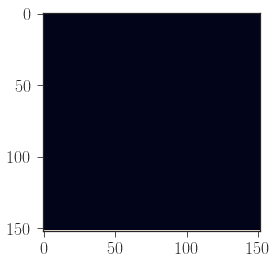

In [11]:
plt.imshow(bc_map[:, 3, :])

In [12]:
num_alleles = 2
rand_alleles = np.random.randint(-num_alleles, 0, size=bc_map.shape)

Let's inoculate a sphere in the center of the domain.

In [13]:
(bc_nx, bc_ny, bc_nz) = bc_map.shape

In [14]:
x_center = bc_nx/2
y_center = bc_ny/2
z_center = bc_nz/2

x = np.arange(bc_nx)
y = np.arange(bc_ny)
z = np.arange(bc_nz)

In [15]:
X, Y, Z = np.meshgrid(x, y, z)
radius = np.sqrt((X-x_center)**2 + (Y - y_center)**2 + (Z - z_center)**2)

In [16]:
R0 = 10

In [17]:
bc_map[radius <= R0] = rand_alleles[radius <= R0]

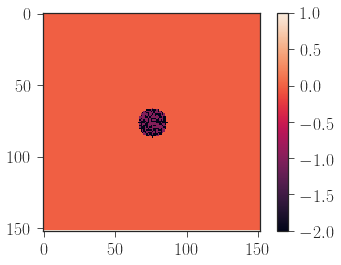

In [18]:
plt.imshow(bc_map[:, bc_ny/2, :])
plt.colorbar()

In [19]:
# Initialize rho...one everywhere, except in the circle where cells were inoculated

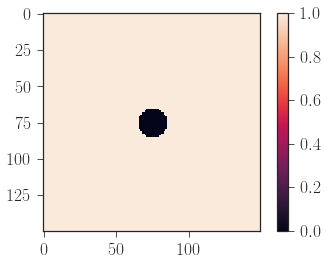

In [20]:
rho = np.ones((nx, ny, nz), dtype=np.double)
bc_in_domain = bc_map[halo:-halo, halo:-halo, halo:-halo]

rho[bc_in_domain < 0] = 0

plt.imshow(rho[:, bc_ny/2, :])
plt.colorbar()

In [21]:
rho.shape

(150, 150, 150)

In [22]:
m0 = 1

2110.57494322


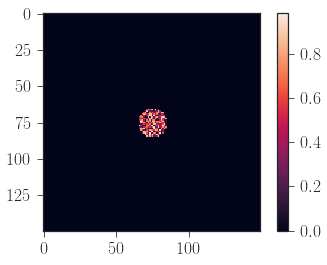

In [23]:
# Initialize the current amount of absorbed mass randomly

absorbed_mass = m0*np.random.rand(nx, ny, nz)
bc_in_domain = bc_map[halo:-halo, halo:-halo, halo:-halo]

absorbed_mass[bc_in_domain >= 0] = 0

plt.imshow(absorbed_mass[:, bc_ny/2, :])
plt.colorbar()

print absorbed_mass.sum()

In [24]:
absorbed_mass.shape

(150, 150, 150)

In [25]:
k0 = .05 #For Da = 600
#k0 = 0.001
k_list = [k0, k0]

m_reproduce_list = [m0, m0]
velocity_set = 'D3Q27'
D = .5 * (1./3.)

Da = nx * k_list[0]/D
print Da

45.0


## Creating the simulation

In [ ]:
sim = lb.DLA_Colony(
    ctx_info=ctx_info, velocity_set=velocity_set,
    bc_map=bc_map, 
    D=D, k_list=k_list, m_reproduce_list=m_reproduce_list,
    absorbed_mass=absorbed_mass, rho=rho)

global size: (160, 152, 152)
local size: (32, 4, 4)
The platforms detected are:
---------------------------
Intel(R) OpenCL Intel(R) Corporation version: OpenCL 1.2 LINUX
The devices detected on platform Intel(R) OpenCL are:
---------------------------
       Intel(R) Core(TM) i7-3537U CPU @ 2.00GHz [Type: CPU ]
Maximum clock Frequency: 2000 MHz
Maximum allocable memory size: 2062 MB
Maximum work group size 8192
Maximum work item dimensions 3
Maximum work item size [8192L, 8192L, 8192L]
---------------------------
This context is associated with  1 devices


/home/bryan/git/LB_colony_growth/LB_colony_growth/LB_colony_growth.py:383: UserWarning: Received OpenCL source code in Unicode, should be ASCII string. Attempting conversion.
  self.kernels = cl.Program(self.context, buf.getvalue()).build(options='')
/home/bryan/anaconda2/lib/python2.7/site-packages/pyopencl/cffi_cl.py:1516: CompilerWarning: From-source build succeeded, but resulted in non-empty logs:
Build on <pyopencl.Device 'Intel(R) Core(TM) i7-3537U CPU @ 2.00GHz' on 'Intel(R) OpenCL' at 0x7f54c3eb71d8> succeeded, but said:

Compilation started
Compilation done
Linking started
Linking done
Device build started
Device build done
Kernel <collide_and_propagate> was successfully vectorized (4)
Kernel <update_after_streaming> was successfully vectorized (8)
Kernel <init_feq> was successfully vectorized (4)
Kernel <reproduce> was not vectorized
Kernel <copy_streamed_onto_f> was successfully vectorized (4)
Kernel <copy_streamed_onto_bc> was successfully vectorized (4)
Done.
  warn(text, 

tau 1.0
omega 1.0
global_size_bc: (160, 152, 152)
Connecting python to the opencl_kernel init_feq...


In [29]:
# What the beginning of the output vtk files will look like
output_str = '/home/bryan/Documents/2018_05_16_LB_colony_growth/spherical_colony/spherical_colony'

In [30]:
sim.output_fields(output_str)

/home/bryan/anaconda2/lib/python2.7/site-packages/tvtk/array_handler.py:268: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  assert not numpy.issubdtype(z.dtype, complex), \


In [31]:
# Outputs vtk files of the population and density field every 50 timesteps

time_to_run = 1000
output_every = 50

num_outputs = time_to_run/output_every

for i in range(num_outputs):
    sim.run(output_every)
    print 'Outputting...', sim.elapsed_time
    sim.output_fields(output_str)

Outputting... 50
Outputting... 100
Outputting... 150
Outputting... 200
Outputting... 250
Outputting... 300
Outputting... 350
Outputting... 400
Outputting... 450
Outputting... 500
Outputting... 550
Outputting... 600
Outputting... 650
Outputting... 700
Outputting... 750
Outputting... 800
Outputting... 850
Outputting... 900
Outputting... 950
Outputting... 1000
